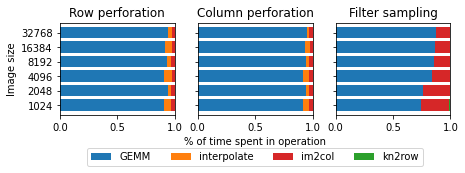

In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

df = pd.read_csv("bench_convs.csv").dropna(axis=1)

mode_mapping = {
    0: "Row perforation",
    1: "Column perforation",
    2: "Filter sampling",
}

df["approx_info.mode_name"] = df["approx_info.mode"].map(lambda x: mode_mapping[x])

total_is = "gemm"

if total_is == "im2col":
    df["approx.total"] = df["approx.im2col"]
    df["normal.total"] = df["normal.im2col"]
if total_is == "gemm":
    df["approx.total"] = df["approx.gemm"]
    df["normal.total"] = df["normal.gemm"]
if total_is == "full":
    df["approx.total"] = df["approx.gemm"] + df["approx.im2col"] + df["approx.interpolate"] + df["approx.kn2row"]
    df["normal.total"] = df["normal.gemm"] + df["normal.im2col"]

df["speedup"] = df["normal.total"] / df["approx.total"]
df["chw"] = df["info.c"] * df["info.h"] * df["info.w"]

df["gemm.K"] = df["info.kh"]*df["info.kw"]*df["info.kn"] * \
    (1 - (df.apply(lambda r: 1/r["approx_info.perf_stride"]
     if r["approx_info.mode"] == 2 else 0, axis=1)))

df["gemm.N"] = df["info.w"]*df["info.h"] * \
    (1 - (df.apply(lambda r: 1/r["approx_info.perf_stride"]
     if r["approx_info.mode"] != 2 else 0, axis=1)))

df["gemm.M"] = df["info.kn"]




def stackbars(ax, bars):
    left = np.zeros((len(bars[0][0]),))
    width = 0.8
    colors=['tab:blue', 'tab:orange', 'tab:red', 'tab:green']
    for i, (data, label) in enumerate(bars):
        data = np.array(data)
        ax.barh(tlabels, data, width, left=left, label=label, fc=colors[i])
        left += np.array(data)


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 1.7), sharey=True)

for ax, mode in zip(axs, [0,1,2]):
    tlabels = []
    gemms = []
    interpolates = []
    im2cols = []
    kn2rows = []
    for name, grp in df[(df["approx_info.mode"] == mode)].groupby("chw"):

        t_gemm = grp["approx.gemm"].mean()
        t_interpolate = grp["approx.interpolate"].mean()
        t_im2col = grp["approx.im2col"].mean()
        t_kn2row = grp["approx.kn2row"].mean()

        t_total = t_im2col + t_gemm + t_interpolate + t_kn2row

        tlabels.append(str(name))
        gemms.append(t_gemm/t_total)
        interpolates.append(t_interpolate/t_total)
        im2cols.append(t_im2col/t_total)
        kn2rows.append(t_kn2row/t_total)





    stackbars(ax, [
        (gemms, "GEMM"),
        (interpolates, "interpolate"),
        (im2cols, "im2col"),
        (kn2rows, "kn2row"),
    ])
    ax.set_xlim((0, 1))
    if mode == 0:
        ax.set_ylabel("Image size")
    ax.set_title(mode_mapping[mode])
    if mode == 1:
        ax.set_xlabel("% of time spent in operation")
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.3),ncol=4)

plt.savefig("conv-scaling.pdf", bbox_inches='tight')